# parallel MLD

并行的最大似然解码器，其中调用MLD模块函数，以及spped_up_mld.ipynb中的函数。

我们考虑两个示例：
* d=3，r=1的示例。
* d=3，r=3的示例。

## d=3, r=1 示例

In [1]:
from MLD import MaxLikelihoodDecoder
import stim

circuit_noisy = stim.Circuit.from_file("./data/surface_code_bZ_d3_r01_center_3_5/circuit_noisy.stim")
detector_error_model = circuit_noisy.detector_error_model()

ml_decoder = MaxLikelihoodDecoder(detector_error_model, detector_error_model.num_detectors)
# 计算每个节点的相邻节点
detector_connectivity = ml_decoder.compute_detector_connectivity(have_logical_observable=False)

查看detector_connectivity的图形化表示。

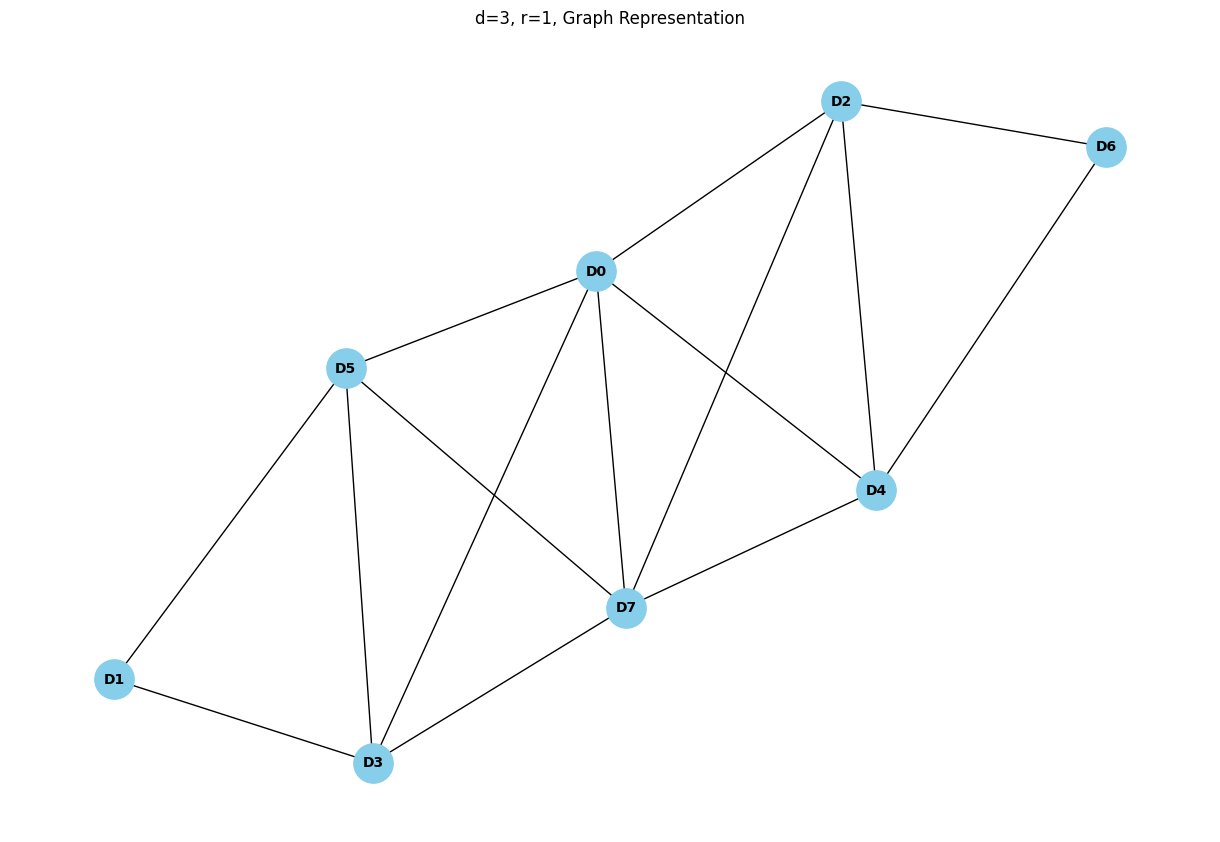

In [2]:
import logging
import matplotlib as mpl

# 设置matplotlib的日志级别为WARNING
mpl.set_loglevel('WARNING')

# 设置全局日志级别为 WARNING
logging.basicConfig(level=logging.WARNING)

import networkx as nx
import matplotlib.pyplot as plt

# 定义邻接列表
edges = detector_connectivity

# 创建图
G = nx.Graph()

# 添加边
for node, neighbors in edges.items():
    for neighbor in neighbors:
        G.add_edge(node, f'D{neighbor}')

# 绘制图
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # 使用弹簧布局
nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=10, font_weight='bold')
plt.title('d=3, r=1, Graph Representation')
plt.show()

我们可以从非detector_connectivity["D0"]中，选择其中一个作为不相邻的detector来并行执行。

不相邻的节点有很多，我们暂时按照顺序，选择最小序号的detector作为并行执行的节点。

可能的选择策略：
* 选择序号最小的节点。
* 选择相邻节点数最小，同时序号最小。
* 选择连接的边数最小，同时序号最小。

我们暂时先考虑最简单的策略，即第一种序号最小。

In [3]:
def min_index_parallel_detectors_method(detector_number, detector_connectivity):
    
    each_step_parallel_detector = []
    
    current_parallel_detector_candidates = list(range(detector_number))
    unexecuted_detectors = list(range(detector_number))
    # 轮次
    num_steps = 0
    while unexecuted_detectors:
        # 多轮进行并行执行：
        # print(f"--------------第{num_steps}轮--------------------")
        # 初始化list
        current_parallel_detector_candidates = unexecuted_detectors.copy()
        current_parallel_detectors = []
        
        while current_parallel_detector_candidates:
            detector = current_parallel_detector_candidates.pop(0)
            current_parallel_detectors.append(detector)
            unexecuted_detectors.remove(detector)

            # 更新current_parallel_detector_candidates，找到所有与current_parallel_detectors不相邻的节点。
            current_parallel_detector_candidates = [i for i in current_parallel_detector_candidates if i not in detector_connectivity[f"D{detector}"]]
            # print(f"当前并行执行的节点: {detector}")
            connected_detector = detector_connectivity[f"D{detector}"]
            # print(f"当前相邻节点: {connected_detector}, 相邻节点数：{len(connected_detector)}")
            # print("后续可以选择的非相邻可并行节点",current_parallel_detector_candidates)
            # print("当前未执行的节点", unexecuted_detectors)
            
        num_steps += 1
        each_step_parallel_detector.append(current_parallel_detectors)
        print(f"--------------第{num_steps}轮执行的节点: {current_parallel_detectors}------------")
    return num_steps, each_step_parallel_detector

num_steps, each_step_parallel_detector = min_index_parallel_detectors_method(ml_decoder.detector_number, detector_connectivity)
print(f"共执行了{num_steps}轮, 每列执行的节点应该为：{each_step_parallel_detector}")

--------------第1轮执行的节点: [0, 1, 6]------------
--------------第2轮执行的节点: [2, 3]------------
--------------第3轮执行的节点: [4, 5]------------
--------------第4轮执行的节点: [7]------------
共执行了4轮, 每列执行的节点应该为：[[0, 1, 6], [2, 3], [4, 5], [7]]


我们能否可视化下面的超图？

In [4]:
detector_error_model

stim.DetectorErrorModel('''
    error(0.009889) D0 D2
    error(0.00341035) D0 D3
    error(0.0329122) D0 D4
    error(0.00433956) D0 D5
    error(0.00921673) D0 D7
    error(0.0145061) D0 L0
    error(0.00400415) D1 D3
    error(0.0299506) D1 D5
    error(0.00278521) D1 L0
    error(0.00965131) D2
    error(0.00488075) D2 D4
    error(0.0252629) D2 D6
    error(0.00467753) D2 D7
    error(0.0176977) D3
    error(0.00325365) D3 D5
    error(0.0357146) D3 D7
    error(0.0139548) D4 D6
    error(0.0160334) D4 D7
    error(0.0626966) D4 L0
    error(0.0226447) D5 D7
    error(0.0197193) D5 L0
    error(0.0108271) D6
    error(0.0564801) D7
    detector(2, 5, 0) D0
    detector(4, 3, 0) D1
    detector(2, 7, 0) D2
    detector(4, 5, 0) D3
    detector(2, 5, 1) D4
    detector(4, 3, 1) D5
    detector(2, 7, 1) D6
    detector(4, 5, 1) D7
''')

定义一个超图类

In [5]:
from MLD_Hypergraph import MLD_Hypergraph

In [6]:
mld_hypergraph = MLD_Hypergraph(detector_error_model=detector_error_model)

### 利用二部图，可视化超图。

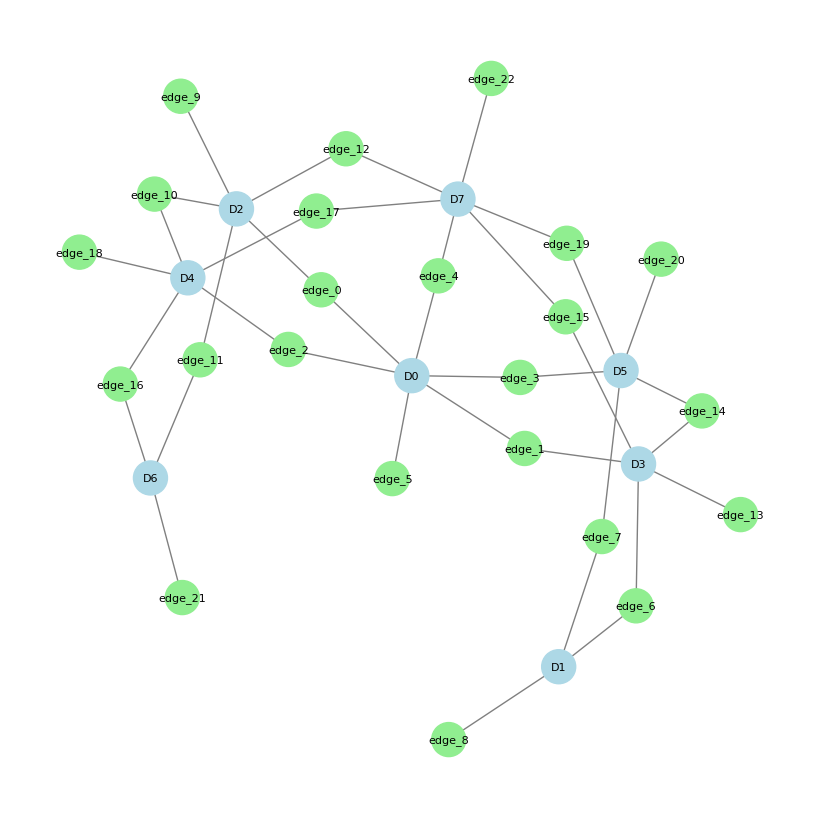

In [7]:
mld_hypergraph.draw_bipartite_graph()

尝试使用hypernetx画超图

In [8]:
# import hypernetx as hnx
# import matplotlib.pyplot as plt

# # 定义超图的节点和超边
# nodes = ['A', 'B', 'C', 'D', 'E']
# hyperedges = {
#     'edge_1': ['A', 'B'],
#     'edge_2': ['B', 'C', 'D'],
#     'edge_3': ['D', 'E']
# }

# # 创建超图
# H = hnx.Hypergraph(hyperedges)

# # 可视化超图
# hnx.draw(H)
# plt.show()


In [12]:
import hypernetx as hnx
# import matplotlib.pyplot as plt

H = mld_hypergraph.to_hypernetx_hypergraph()
# # 可视化超图
hnx.draw(H)
plt.show()